In [1]:
%matplotlib notebook
# %matplotlib ipympl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Generate Dataframe of all keypoints from JSON file

In [2]:
keypoints_all = pd.read_json('./Keypoints_All.json', orient='records')
# new_columns = ['Gesture', 'Sub folder No.', 'Frame No.', 'Person', 'Joint', 'X', 'Y', 'Probability', 'Depth']
new_columns = ['Gesture', 'Sub folder No.', 'Frame No.', 'Joint', 'X', 'Y', 'Probability', 'Depth']
keypoints_all = keypoints_all.reindex(columns = new_columns)
print('keypoints_all shape', keypoints_all.shape)
keypoints_all.head()

keypoints_all shape (222075, 8)


,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Probability,Depth
0,1,1,1,0,648.913696,165.119186,0.935339,0.352941
1,1,1,1,1,650.893982,268.933197,0.867646,0.352941
2,1,1,1,2,576.504761,270.824951,0.772305,0.360784
3,1,1,1,3,556.990112,382.489716,0.813767,0.360784
4,1,1,1,4,554.818665,494.189514,0.862577,0.325490


#### Generate Dataframe of keypoints 1-7

In [3]:
keypoints_1_7 = keypoints_all[keypoints_all['Joint'].isin(range(1,8))]
print('keypoints_1_7 shape', keypoints_1_7.shape)

keypoints_1_7 shape (62181, 8)


#### Check Probability (from OpenPose output) per folder

<IPython.core.display.Javascript object>


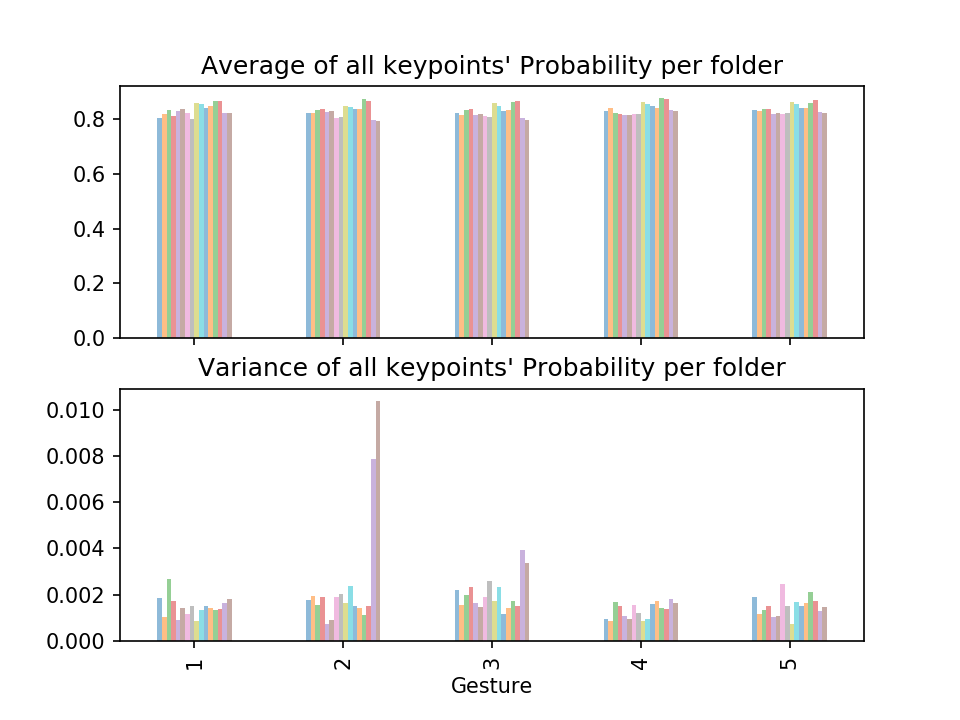

In [4]:
fig, axes = plt.subplots(2,1, sharex=True)
pd.pivot_table(keypoints_1_7, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='mean').plot(kind='bar', ax=axes[0], title='Average of all keypoints\' Probability per folder', legend=False, alpha=0.5)
pd.pivot_table(keypoints_1_7, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='var').plot(kind='bar', ax=axes[1], title='Variance of all keypoints\' Probability per folder', legend=False, alpha=0.5)

#### Observe distribution of Probability

<IPython.core.display.Javascript object>


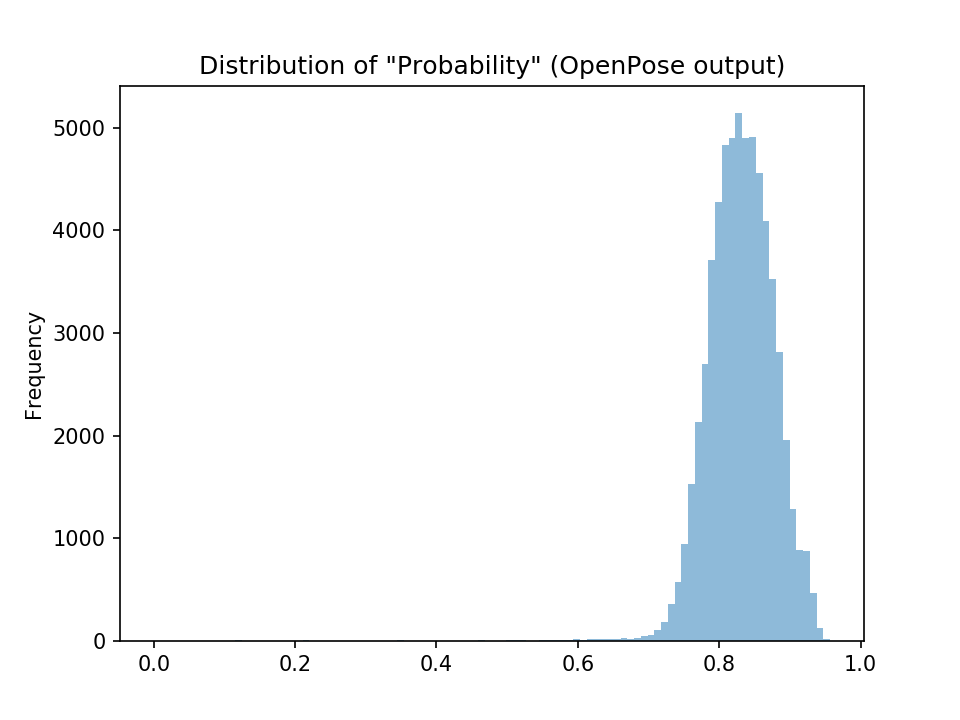

In [6]:
fig = plt.figure()
keypoints_1_7['Probability'].plot.hist(bins=100, title='Distribution of \"Probability\" (OpenPose output)', alpha=0.5)

#### Get Probability value at percentile 5, use it as probability threshold for later data cleaning

In [9]:
prob_threshold = keypoints_1_7['Probability'].quantile(0.01)
print(prob_threshold)

0.7249381423200001


#### Calculate the percentage of "low probability keypoints" (keypoints probability < probability threshold) per foler

<IPython.core.display.Javascript object>


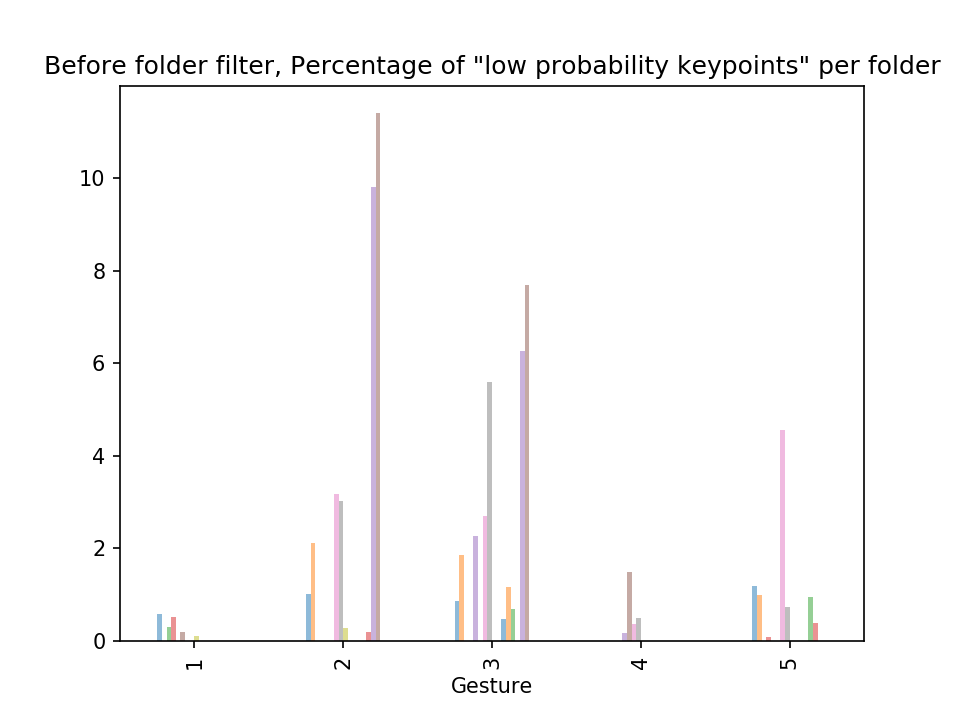

In [10]:
keypoints_1_7_folder_prob_threshold_percent = keypoints_1_7.pivot_table(index = ['Gesture', 'Sub folder No.'], values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100)
keypoints_1_7.pivot_table(index = 'Gesture', columns = 'Sub folder No.', values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100).plot.bar(title='Before folder filter, Percentage of \"low probability keypoints\" per folder', legend=False, alpha=0.5)

#### Filter the folders and keey only the folders has less than 10 percent of "low probability keypoints" 

In [11]:
low_prob_keypoints_percentage_threshold = 8
keypoints_1_7_folder_filtered_index = keypoints_1_7_folder_prob_threshold_percent[keypoints_1_7_folder_prob_threshold_percent['Probability'] < low_prob_keypoints_percentage_threshold].index.tolist()
keypoints_1_7_folder_filtered = keypoints_1_7[keypoints_1_7[['Gesture','Sub folder No.']].apply(lambda x:(x[0],x[1]) in keypoints_1_7_folder_filtered_index, axis=1)]

print('keypoints_1_7_filtered shape', keypoints_1_7_folder_filtered.shape)

keypoints_1_7_filtered shape (60032, 8)


<IPython.core.display.Javascript object>


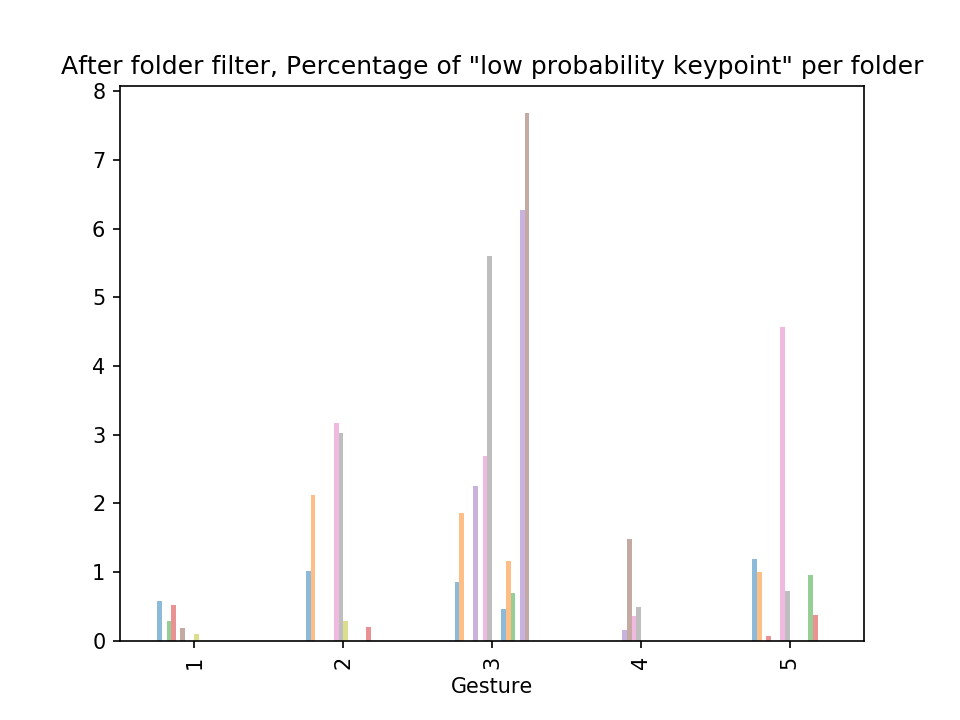

In [12]:
keypoints_1_7_folder_filtered.pivot_table(index = 'Gesture', columns = 'Sub folder No.', values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100).plot.bar(title='After folder filter, Percentage of \"low probability keypoint\" per folder', legend=False, alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


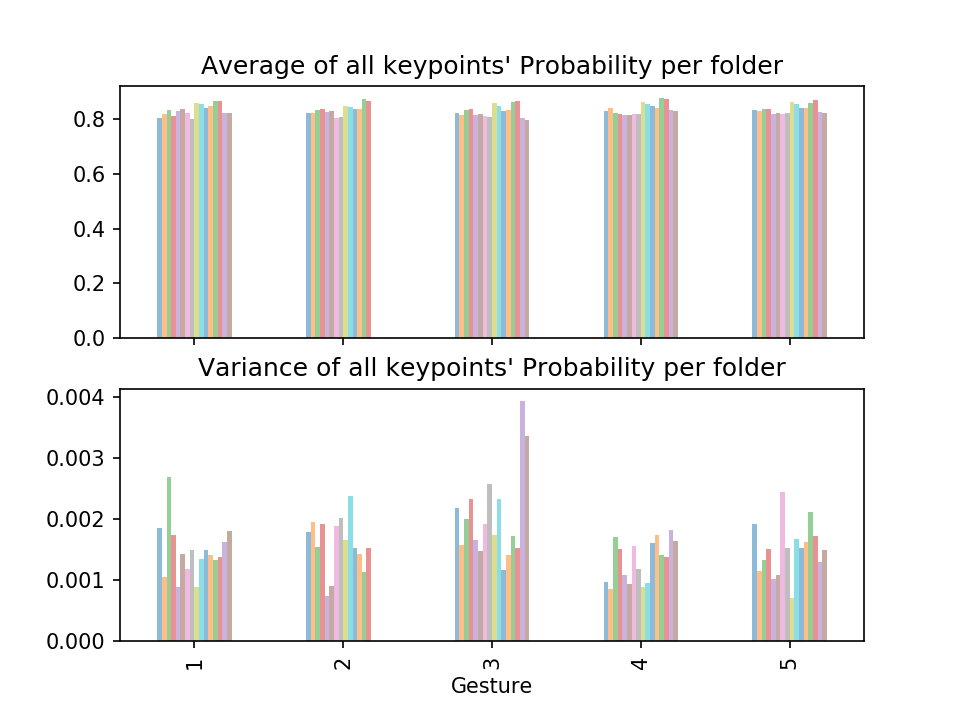

In [13]:
fig, axes = plt.subplots(2,1, sharex=True)
pd.pivot_table(keypoints_1_7_folder_filtered, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='mean').plot(kind='bar', ax=axes[0], title='Average of all keypoints\' Probability per folder', legend=False, alpha=0.5)
pd.pivot_table(keypoints_1_7_folder_filtered, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='var').plot(kind='bar', ax=axes[1], title='Variance of all keypoints\' Probability per folder', legend=False, alpha=0.5)

#### Check the X values of Joint 3 in all frames, we can see there are 0 values, this also need to be cleaned

In [ ]:
# keypoints_1_7_folder_filtered[keypoints_1_7_folder_filtered['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='X').plot.line(alpha=0.5)

#### We use Weighted Moving Average Smoothing to clean the 0 values of X and Y.
#### First, prepare a dataframe with t-1 and t+1 values for each keypoints

In [ ]:
# df = pd.concat([keypoints_1_7_folder_filtered, keypoints_1_7_folder_filtered.shift(7)[['X', 'Y', 'Probability']].rename(columns={'X':'X(t-1)', 'Y':'Y(t-1)', 'Probability':'Probability(t-1)'}), keypoints_1_7_folder_filtered.shift(-7)[['X', 'Y', 'Probability']].rename(columns={'X':'X(t+1)', 'Y':'Y(t+1)', 'Probability':'Probability(t+1)'})], axis=1)
# df.head(14)

#### Use Weighted Moving Average Smoothing to calculate X_cleaned and Y_cleaned

In [ ]:
# X_cleaned = df.apply(lambda row: (row['X']*row['Probability'] + row['X(t-1)']*row['Probability(t-1)'] + row['X(t+1)']*row['Probability(t+1)'])/(row['Probability']+row['Probability(t-1)']+row['Probability(t+1)']) if row['Probability']==0 else row['X'], axis=1)
# Y_cleaned = df.apply(lambda row: (row['Y']*row['Probability'] + row['Y(t-1)']*row['Probability(t-1)'] + row['Y(t+1)']*row['Probability(t+1)'])/(row['Probability']+row['Probability(t-1)']+row['Probability(t+1)']) if row['Probability']==0 else row['Y'], axis=1)

#### Add cleaned X and Y to the original dataframe

In [ ]:
# keypoints_1_7_frame_cleaned = pd.concat([keypoints_1_7_folder_filtered, X_cleaned.rename('X_cleaned'), Y_cleaned.rename('Y_cleaned')], axis=1)
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].head()

#### Recheck the X values of Joint 3 in all frames, we can see no more 0 values

In [ ]:
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='X_cleaned').plot.line(alpha=0.5)

#### After data cleaning of OpenPose data, we also need to clean depth data

#### Check the depth value when probability == 0 (aka. X==0 and Y==0)

In [ ]:
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].pivot_table(index = ['Frame No.', 'Joint'], columns = ['Gesture', 'Sub folder No.'], values='Depth').swapaxes(axis1=0, axis2=1)

#### When Probability == 0, it means that the keypoint is occluded. To estimate the depth value, we use Moving Average Smoothing: get average of depth data at t-1 and t+1

In [ ]:
# df = pd.concat([keypoints_1_7_frame_cleaned, keypoints_1_7_frame_cleaned.shift(7)['Depth'].rename('Depth(t-1)'), keypoints_1_7_frame_cleaned.shift(-7)['Depth'].rename('Depth(t+1)')], axis=1)
# Depth_cleaned = df[['Probability', 'Depth', 'Depth(t-1)', 'Depth(t+1)']].apply(lambda x: np.mean((x[2], x[3])) if x[0]==0 else x[1], axis=1)
# keypoints_1_7_frame_cleaned['Depth_cleaned'] = Depth_cleaned
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].head()

#### Now check the depth data of Joint 1 in all frames, we can see abnormal depth values (noise)

<IPython.core.display.Javascript object>


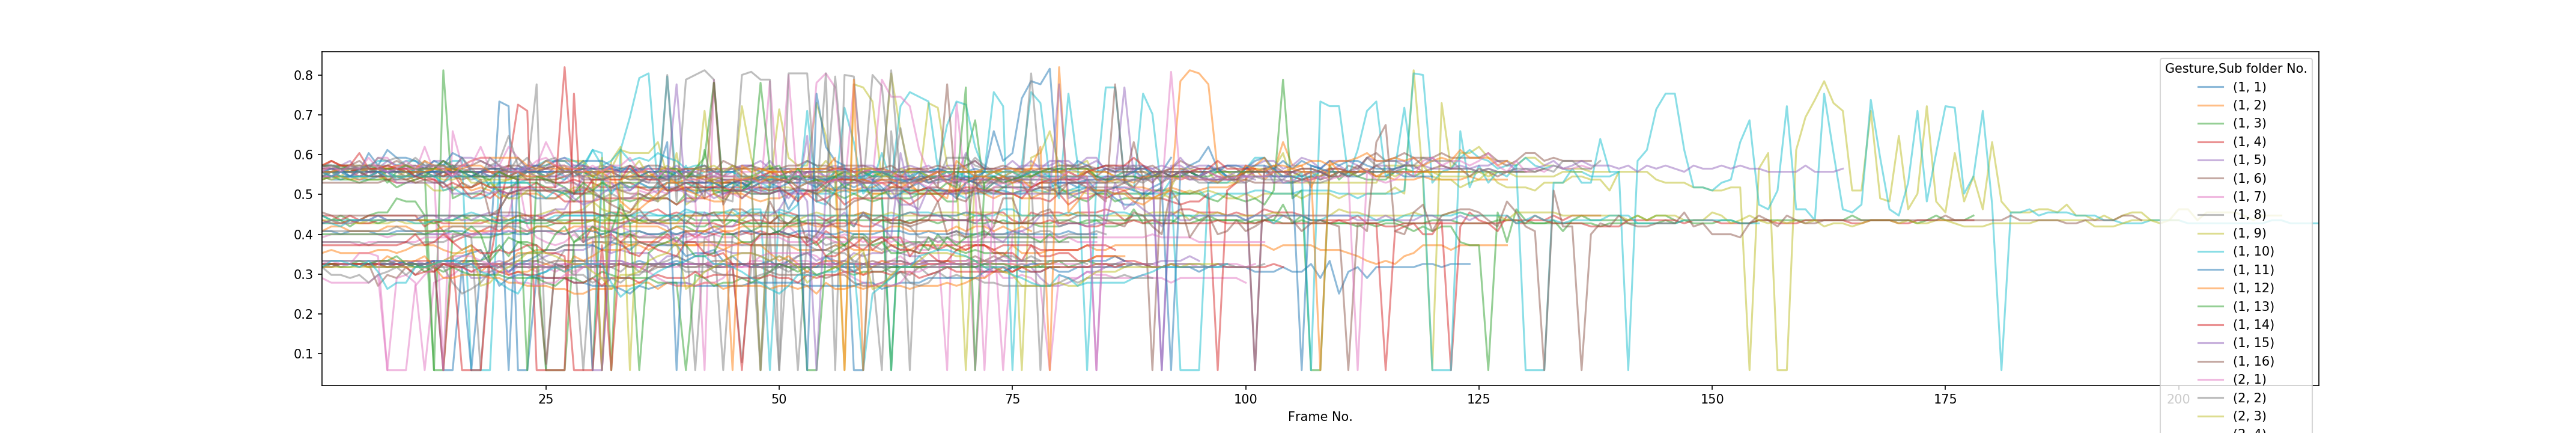

In [16]:
# keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Joint']==1].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='Depth_cleaned').plot.line(alpha=0.5)
keypoints_1_7_folder_filtered[np.logical_and(keypoints_1_7_folder_filtered['Joint']==4, keypoints_1_7_folder_filtered['Gesture']<8)].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='Depth').plot.line(alpha=0.5)

#### Let's see the distribution of the difference of each frame's depth comparing to the median depth of each Joint

In [ ]:
# Depth_median = keypoints_1_7_frame_cleaned.pivot_table(index = ['Gesture', 'Sub folder No.', 'Joint'], values = 'Depth_cleaned', aggfunc = lambda x: np.median(x)).rename(columns={'Depth_cleaned':'Depth_median'})
# df = keypoints_1_7_frame_cleaned.join(Depth_median, on=['Gesture', 'Sub folder No.', 'Joint'])
# df['Depth_cleaned - Depth_median'] = df['Depth_cleaned'] - df['Depth_median']
# df.pivot_table(index = ['Sub folder No.', 'Frame No.'], columns = ['Gesture', 'Joint'], values = 'Depth_cleaned - Depth_median').plot.hist(bins=200, alpha=0.5)
Depth_median = keypoints_1_7_folder_filtered.pivot_table(index = ['Gesture', 'Sub folder No.', 'Joint'], values = 'Depth', aggfunc = lambda x: np.median(x)).rename(columns={'Depth':'Depth_median'})
df = keypoints_1_7_folder_filtered.join(Depth_median, on=['Gesture', 'Sub folder No.', 'Joint'])
df['Depth - Depth_median'] = df['Depth'] - df['Depth_median']
df.pivot_table(index = ['Sub folder No.', 'Frame No.'], columns = ['Gesture', 'Joint'], values = 'Depth - Depth_median').plot.hist(bins=200, alpha=0.5)

In [ ]:
# depth_percentile_left = df.pivot_table(index = ['Gesture', 'Joint'], values = 'Depth_cleaned - Depth_median', aggfunc = lambda x: x.quantile(0.02)).rename(columns={'Depth_cleaned - Depth_median':'Depth_confidence_interval_left'})
# depth_percentile_right = df.pivot_table(index = ['Gesture', 'Joint'], values = 'Depth_cleaned - Depth_median', aggfunc = lambda x: x.quantile(0.98)).rename(columns={'Depth_cleaned - Depth_median':'Depth_confidence_interval_right'})
depth_percentile_left = df.pivot_table(index = ['Gesture', 'Joint'], values = 'Depth - Depth_median', aggfunc = lambda x: x.quantile(0.02)).rename(columns={'Depth - Depth_median':'Depth_confidence_interval_left'})
depth_percentile_right = df.pivot_table(index = ['Gesture', 'Joint'], values = 'Depth - Depth_median', aggfunc = lambda x: x.quantile(0.98)).rename(columns={'Depth - Depth_median':'Depth_confidence_interval_right'})

In [ ]:
df2 = df.join(depth_percentile_left, on=['Gesture', 'Joint'])
df2 = df2.join(depth_percentile_right, on=['Gesture', 'Joint'])
df2.head()

In [ ]:
keypoints_1_7_folder_filtered.pivot_table(index = ['Joint'], values = 'Depth', aggfunc = lambda x: np.count_nonzero(x==0))

In [ ]:
keypoints_1_7_folder_filtered.pivot_table(index = ['Joint'], values = 'Depth', aggfunc = lambda x: np.median(x))